# Import packages and data

In [3]:
#!pip install pyarabic
#!pip install tashaphyne
#!pip install wordcloud
#!pip install farasapy

In [139]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.model_selection import GridSearchCV
from nltk.tokenize import word_tokenize
from nltk.stem.isri import ISRIStemmer
import regex as re
import nltk
import string
import numpy as np
from tashaphyne.stemming import ArabicLightStemmer

from farasa.pos import FarasaPOSTagger
from farasa.ner import FarasaNamedEntityRecognizer
from farasa.diacratizer import FarasaDiacritizer
from farasa.segmenter import FarasaSegmenter
from farasa.stemmer import FarasaStemmer

import pyLDAvis.sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
from ar_wordcloud import ArabicWordCloud
%matplotlib inline

#import pyarabic.arabrepr
#import unicodedata as ud
#from sklearn.metrics.pairwise import cosine_similarity
#from gensim import corpora, models, similarities, utils
#from gensim.parsing.preprocessing import STOPWORDS
#from collections import OrderedDict
#from pyarabic.araby import tokenize, is_arabicrange, strip_tashkeel

import warnings
warnings.filterwarnings("ignore")

In [15]:
df1 = pd.read_json(r'dataset/2015-07-22.json')
df2 = pd.read_json(r'dataset/2015-07-23.json')
df3 = pd.read_json(r'dataset/2015-07-24.json')
df4 = pd.read_json(r'dataset/2015-07-25.json')
df5 = pd.read_json(r'dataset/2015-07-26.json')
df6 = pd.read_json(r'dataset/2015-07-27.json')
df7 = pd.read_json(r'dataset/2015-07-31.json')

data = pd.concat([df1,df2,df3,df4,df5,df6,df7])

# Exploring the data

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12070 entries, 0 to 2217
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   source          12070 non-null  object
 1   url             12070 non-null  object
 2   date_extracted  12070 non-null  object
 3   title           12070 non-null  object
 4   author          12070 non-null  object
 5   content         12070 non-null  object
dtypes: object(6)
memory usage: 660.1+ KB


In [17]:
data.head()

,source,url,date_extracted,title,author,content
0,aawsat,http://aawsat.com/home/article/411641/الفقر-أح...,2015-07-22 00:05:53,الفقر أحد أسباب تأخر النمو العقلي لدى الأطفال,القاهرة: «الشرق الأوسط أونلاين»,توصلت دراسة جديدة إلى أن الفقر يؤثر على مخ الأ...
1,aawsat,http://aawsat.com/home/article/411671/«العملة-...,2015-07-22 01:18:37,«العملة المعدنية» السعودية تسجل انحسارًا تاريخ...,الرياض: محمد الحميدي,في وقت تتهيأ فيه السعودية لإطلاق الإصدار الثان...
2,aawsat,http://aawsat.com/home/article/411676/أزمة-توق...,2015-07-22 01:18:42,أزمة توقف نفط {المنطقة المحايدة} قد تطول مع إج...,الخبر: وائل مهدي,يبدو أن توقف إنتاج النفط من الحقول البرية في ا...
3,aawsat,http://aawsat.com/home/article/411681/انتعاش-ا...,2015-07-22 01:18:48,انتعاش الخام مع تراجع الدولار,لندن: «الشرق الأوسط»,انتعشت أسعار العقود الآجلة للنفط الخام أمس الث...
4,aawsat,http://aawsat.com/home/article/411646/تركيا-و«...,2015-07-22 01:18:55,تركيا و«داعش».. نهاية شهر العسل,بيروت: ثائر عباس,لم يكل المسؤولون الأتراك عن نفي الاتهامات الكث...


In [305]:
# creating a copy of the original data
df = data.copy()

# NLP Preprocessing

#### 1. Removing unneeded columns

In [306]:
df.drop(columns=['url','source','date_extracted'],axis=0,inplace=True)

#### 2. Removing Non-arabic letters, numbers and special characters

In [307]:
# remove english numbers
df.content = df.content.apply(lambda x: re.sub(r'[0-9]+', '', x))

# remove english letters
df.content = df.content.apply(lambda x: re.sub(r'[a-zA-Z]', '', x))

# remove a special character _
df.content = df.content.apply(lambda x: re.sub(r'[_]+', '', x))

# remove punctuations
arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
english_punctuations = string.punctuation
punctuations_list = arabic_punctuations + english_punctuations
df.content = df.content.apply(lambda x: x.translate(str.maketrans('', '', punctuations_list)))


# remove newline characters
df.content = df.content.apply(lambda x: x.replace("\n", ""))

#### 3. Stemming

In [308]:
farasa_st = FarasaStemmer()

In [309]:
# st = ISRIStemmer()
# ArListem = ArabicLightStemmer()

# def stemSentence(sentence):
#     token_words=word_tokenize(sentence)
#     stem_sentence=[]
#     for word in token_words:
#         stem_sentence.append(farasa_st.stem(word))
#         #stem_sentence.append(ArListem.light_stem(word))
#         stem_sentence.append(" ")
#     return "".join(stem_sentence)

# df.content = df.content.apply(lambda x: stemSentence(x))

#### 3. TF-IDF Vectorizer

In [311]:
# the document-term matrix 
arb_stopwords = set(nltk.corpus.stopwords.words("arabic"))
tfidf = TfidfVectorizer(stop_words=arb_stopwords)
doc_words = tfidf.fit_transform(df.content)
pd.DataFrame(doc_words.toarray(),columns=tfidf.get_feature_names())

,éوتعتمد,ءات,آآآه,آال,آبأغسطس,آبإلى,آبا,آباء,آباءنا,آباءهم,...,ﻹستقرار,ﻹصابة,ﻹقالة,ﻹكمال,ﻹنجاح,ﻹنشائه,ﻹﻋﺎﺩﺓ,ﻹﻳﻘﺎﻑ,ﻻت,ﻻستئصال
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12065,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12066,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12067,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# EDA

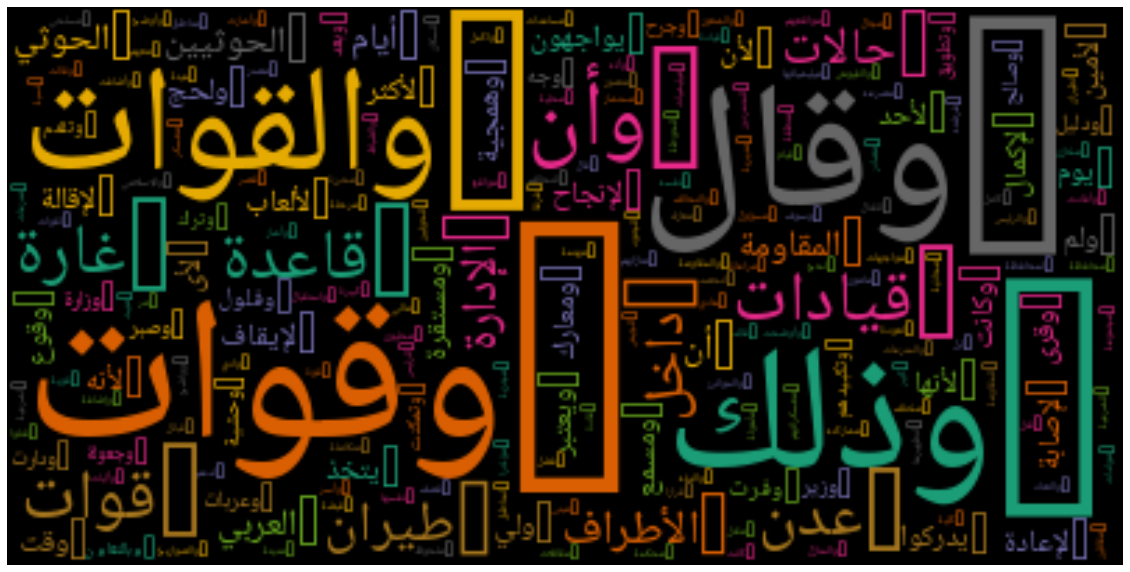

In [298]:
# print WordCloud visualization

awc = ArabicWordCloud(background_color="black",)

mpl.rcParams['figure.figsize']=(20,12.0)  
mpl.rcParams['font.size']=12            
mpl.rcParams['savefig.dpi']=100             
mpl.rcParams['figure.subplot.bottom']=.1 

# wordcloud = awc.generate(str(tfidf.get_feature_names())).from_text(
#     str(tfidf.get_feature_names()))

wordcloud = awc.generate(str(tfidf.get_feature_names())).from_text(str(tfidf.get_feature_names()))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud.recolor(colormap='Dark2'),interpolation='bilinear')
#plt.title("Word Cloud of all the words")
plt.axis('off')
plt.show();

# Clustring

#### 1. K-mean

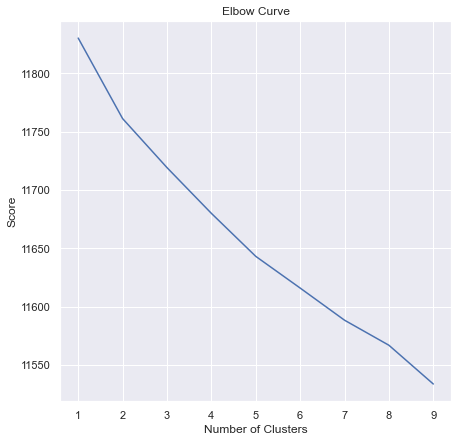

Plotting the Elbow curve took:149.4s 


In [165]:
import seaborn as sns
import time
sns.set(rc= {'figure.figsize': (7,7)})
number_of_clusters = range(1,10)

t0= time.time()
kmeans = [KMeans(n_clusters=i,max_iter=1000,random_state=33,n_jobs=-1) for i in number_of_clusters]
score = [-1*kmeans[i].fit(doc_words).score(doc_words) for i in range(len(kmeans))]
t1= time.time()

plt.plot((number_of_clusters),score)
plt.xlabel('Number of Clusters')
plt.xticks(number_of_clusters)
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

print("Plotting the Elbow curve took:{:.1f}s ".format(t1-t0))

# Topic Modeling

#### 1. NMF

In [317]:
# function to display topics with words


def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
#         else:
#             print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
    

def display_top(model, feature_names, no_top_words, topic_names=None):
    
    my_dict = {'topic_0':'','topic_1':'','topic_2':'','topic_3':'','topic_4':''}
    ctr = 0
    for ix, topic in enumerate(model.components_):
                #if not topic_names or not topic_names[ix]:
#             print("\nTopic ", ix)
        txt = ",".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])
        my_dict['topic_'+str(ctr)] = txt
        ctr+=1
#         print('words are::: ',txt)
    return my_dict

In [35]:
topic_nums = list(np.arange(3, 10, 1))

#nmf_models = []
for num in topic_nums:
    nmf = NMF(num)
    #nmf_models.append(nmf)
    nmf.fit_transform(doc_words)
    display_topics(nmf, tfidf.get_feature_names(), 50)
    print("------------------------------------------")


Topic  0
الفريق, خلال, العام, بنسبة, النادي, الاتحاد, العمل, المائة, عام, إدارة, الأول, مليون, عدد, الماضي, تم, اللاعب, أنه, مليار, اليوم, السعودية, السعودي, أسعار, القدم, نادي, اللاعبين, الشركة, العامة, الشباب, وذلك, شركة, المقبل, النفط, الأهلي, الموسم, مستوى, الهلال, بشكل, يوم, الفترة, فريق, المملكة, المدرب, وفي, العالم, عبر, مدير, العيد, وزارة, الرياض, السوق

Topic  1
بن, عبدالعزيز, ولي, الأمير, سلمان, الملكي, السمو, وزير, الحرمين, الشريفين, الملك, محمد, العهد, خادم, الله, مجلس, صاحب, الوزراء, سعود, الدفاع, رئيس, العربية, آل, الدكتور, المملكة, مصر, جمهورية, نايف, البلدين, لرئيس, عبدالله, الاستقبال, أمير, النائب, خالد, وصاحب, سموه, مساعد, نائب, الخارجية, معالي, فيصل, الرئيس, ومعالي, منطقة, الإنسانية, العلاقات, السيسي, للإغاثة, الشقيقين

Topic  2
عدن, داعش, المقاومة, اليمن, التحالف, الحوثيين, إيران, تنظيم, تركيا, سوريا, قوات, الحوثي, اليمني, الشعبية, التركية, ان, اليمنية, وقال, مدينة, ضد, القوات, العراق, المتحدة, الرئيس, محافظة, الجيش, صالح, الاتفاق, الى, حزب, الحكومة, الأمن, التنظيم


Topic  0
الفريق, النادي, اللاعب, الاتحاد, اللاعبين, نادي, القدم, المدرب, الموسم, الأهلي, إدارة, لكرة, فريق, الأول, المقبل, الفني, المعسكر, لاعب, النصر, الهلال, المباراة, الودية, التدريبات, مدرب, الملعب, السعودي, الجهاز, خلال, الشباب, مباراة, الدوري, معسكر, الإدارة, للفريق, بولوني, الروماني, الجديد, كأس, تدريبات, بنادي, دوري, الكرة, سان, معسكره, كرة, الماضي, للموسم, الأندية, السوبر, البلوي

Topic  1
بن, ولي, عبدالعزيز, الأمير, وزير, السمو, الملكي, الحرمين, سلمان, الشريفين, العهد, محمد, خادم, مجلس, الوزراء, صاحب, العربية, سعود, الله, رئيس, الدفاع, مصر, آل, جمهورية, الملك, المملكة, البلدين, الاستقبال, نايف, وصاحب, لرئيس, الخارجية, مساعد, النائب, ومعالي, الدكتور, الرئيس, السيسي, الشقيقين, نائب, سموه, خالد, عادل, العلاقات, أمير, ووزير, الثاني, عبدالفتاح, حضر, بحث

Topic  2
عدن, المقاومة, الحوثيين, الحوثي, الشعبية, اليمن, التحالف, اليمني, صالح, قوات, محافظة, وقوات, اليمنية, تعز, مدينة, الموالية, العند, لحج, المدينة, هادي, مصادر, صنعاء, الحوثية, القوات, المخلوع, الرئيس, الميليشيات, ميليشيات,

In [313]:
nmf_model = NMF(5)
doc_topic = nmf_model.fit_transform(doc_words)

In [315]:
topic_word = pd.DataFrame(nmf_model.components_.round(3),
             index = ["component_1","component_2","component_3","component_4","component_5"],
             columns = tfidf.get_feature_names())
topic_word

,éوتعتمد,ءات,آآآه,آال,آبأغسطس,آبإلى,آبا,آباء,آباءنا,آباءهم,...,ﻹستقرار,ﻹصابة,ﻹقالة,ﻹكمال,ﻹنجاح,ﻹنشائه,ﻹﻋﺎﺩﺓ,ﻹﻳﻘﺎﻑ,ﻻت,ﻻستئصال
component_1,0.0,0.0,0.0,0.000,0.003,0.001,0.0,0.000,0.0,0.000,...,0.0,0.001,0.0,0.000,0.001,0.000,0.000,0.0,0.0,0.0
component_2,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.000,0.0,0.000,...,0.0,0.000,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.0
component_3,0.0,0.0,0.0,0.000,0.003,0.000,0.0,0.001,0.0,0.000,...,0.0,0.000,0.0,0.000,0.000,0.000,0.001,0.0,0.0,0.0
component_4,0.0,0.0,0.0,0.000,0.002,0.000,0.0,0.001,0.0,0.000,...,0.0,0.000,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.0
component_5,0.0,0.0,0.0,0.001,0.000,0.000,0.0,0.002,0.0,0.001,...,0.0,0.000,0.0,0.004,0.000,0.001,0.000,0.0,0.0,0.0


In [322]:
display_topics(nmf_model, tfidf.get_feature_names(), 50)


Topic  0
الفريق, النادي, اللاعب, الاتحاد, اللاعبين, نادي, القدم, المدرب, الموسم, الأهلي, لكرة, إدارة, فريق, الأول, المقبل, الفني, المعسكر, لاعب, الهلال, النصر, المباراة, الودية, التدريبات, مدرب, الملعب, السعودي, خلال, الجهاز, الشباب, مباراة, الدوري, معسكر, الإدارة, للفريق, بولوني, كأس, الجديد, الروماني, تدريبات, بنادي, سان, دوري, الكرة, ان, كرة, معسكره, الماضي, للموسم, الأندية, السوبر

Topic  1
بن, ولي, عبدالعزيز, سلمان, الأمير, الملكي, وزير, السمو, الحرمين, الشريفين, العهد, الملك, خادم, محمد, مجلس, الوزراء, الله, صاحب, سعود, الدفاع, العربية, رئيس, آل, مصر, جمهورية, المملكة, الدكتور, البلدين, لرئيس, الاستقبال, النائب, نايف, وصاحب, الخارجية, مساعد, الرئيس, ومعالي, الإنسانية, نائب, السيسي, للإغاثة, عبدالله, الشقيقين, الثاني, معالي, سموه, خالد, العلاقات, عادل, ووزير

Topic  2
عدن, داعش, المقاومة, إيران, اليمن, التحالف, تنظيم, تركيا, سوريا, الحوثيين, قوات, الحوثي, ان, اليمني, الاتفاق, وقال, التركية, ضد, المتحدة, العراق, الشعبية, الرئيس, مدينة, القوات, الى, الجيش, اليمنية, الحكومة, حزب, صا

In [1]:
dictt = display_top(nmf_model, tfidf.get_feature_names(), 50)
#dictt['topic_0'].split(',')

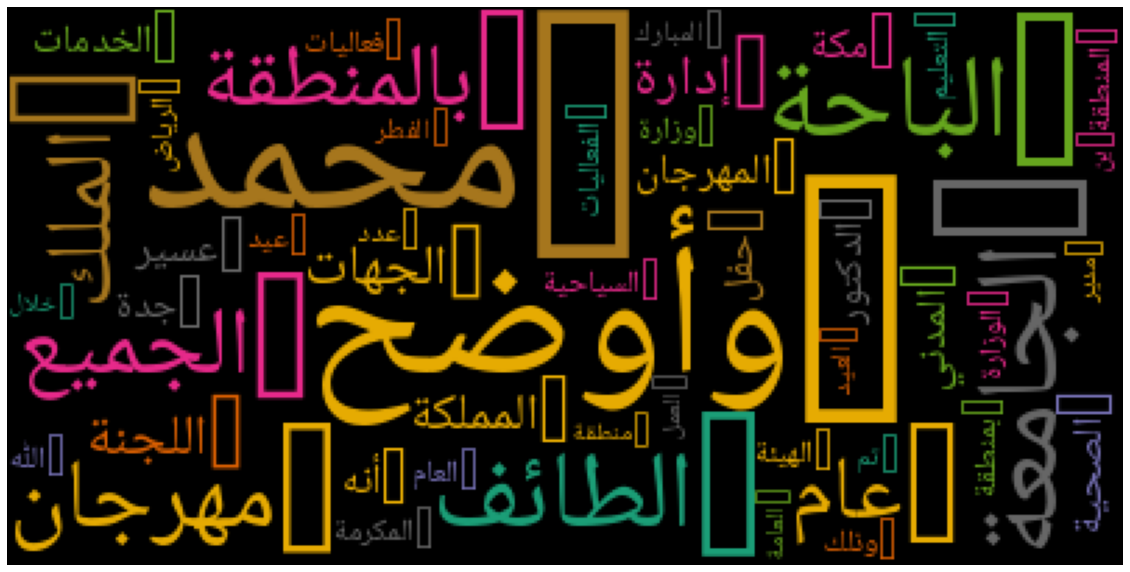

In [331]:
# print WordCloud visualization

awc = ArabicWordCloud(background_color="black")

mpl.rcParams['figure.figsize']=(20,12.0)  
mpl.rcParams['font.size']=12            
mpl.rcParams['savefig.dpi']=100             
mpl.rcParams['figure.subplot.bottom']=.1 

wordcloud = awc.generate(str(dictt['topic_4'].split(','))).from_text(
    str(dictt['topic_4'].split(',')))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud.recolor(colormap='Dark2'))
plt.axis('off')
plt.show();

#### 2. LDA

In [339]:
# Define Search Param
search_params = {'n_components': [10, 9, 8, 7, 6, 5, 4, 3], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(doc_words)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [10, 9, 8, 7, 6, 5, 4, 3]})

In [340]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(doc_words))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 3}
Best Log Likelihood Score:  -333938.42371468584
Model Perplexity:  114092.89748166587


In [341]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(doc_words)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(10).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,dominant_topic
Doc0,0.030000,0.030000,0.940000,2
Doc1,0.020000,0.020000,0.960000,2
Doc2,0.030000,0.030000,0.950000,2
Doc3,0.020000,0.020000,0.960000,2
Doc4,0.020000,0.020000,0.960000,2
Doc5,0.040000,0.030000,0.930000,2
Doc6,0.020000,0.020000,0.960000,2
Doc7,0.020000,0.020000,0.960000,2
Doc8,0.020000,0.020000,0.950000,2
Doc9,0.020000,0.020000,0.950000,2


In [342]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, doc_words, tfidf, mds='tsne'col)
panel

PreparedData(topic_coordinates=                 x            y  topics  cluster       Freq
topic                                                      
2     -1015.700562  1338.981201       1        1  92.762598
0      -387.996002  -373.316162       2        1   4.101387
1     -2184.745605   -60.565800       3        1   3.136015, topic_info=            Term       Freq      Total Category  logprob  loglift
90076        عدن  11.000000  11.000000  Default  30.0000  30.0000
19539    التحالف  14.000000  14.000000  Default  29.0000  29.0000
44185     اليمني  14.000000  14.000000  Default  28.0000  28.0000
99426       قوات  19.000000  19.000000  Default  27.0000  27.0000
40006   المقاومة   7.000000   7.000000  Default  26.0000  26.0000
...          ...        ...        ...      ...      ...      ...
59032     بمشيئة   0.183556   4.403759   Topic3  -9.9559   0.2845
141162   والباحة   0.149277   1.987111   Topic3 -10.1626   0.8736
18126      البحر   0.197353  13.576456   Topic3  -9.8834  -0.7689
29614      الطقس   0.155719   3.716723   Topic3 -10.1203   0.2897
120751     متوسط   0.151680   8.024186   Topic3 -10.1466  -0.5062

[161 rows x 6 columns], token_table=        Topic      Freq     Term
term                            
5553        1  1.001408      أنه
6104        1  0.813604    أوغلو
6104        2  0.813604    أوغلو
6901        1  0.993130    إدارة
7582        2  1.194959   إغاثية
...       ...       ...      ...
164187      1  1.004633     وقال
164603      1  0.616035    وقوات
164603      2  0.308017    وقوات
165684      2  1.191993  ولحكومة
171627      1  0.747387     ووسط

[151 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

In [345]:
pyLDAvis.save_html(panel, 'lda.html')